In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Download the plain text dataset
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

2022-09-17 17:08:44.256774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 17:08:44.363340: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 17:08:44.365568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 17:08:44.370741: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [3]:
# Get the train and test sets
train_data, test_data = imdb['train'], imdb['test']

# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Loop over all training examples and save the sentences and labels
for s,l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())

# Loop over all test examples and save the sentences and labels
for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())

# Convert labels lists to numpy array
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

#### Build vocab from scratch and generate padded sequences
Use Tokenizer and pad_sequences()

In [4]:
# Parameters
vocab_size = 10000
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [6]:
import matplotlib.pyplot as plt

# Plot Utility for visualizing accuracy and loss history after training
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

#### Model 1: Flatten
Use a Flatten layer after the embedding. Advantage is that it train fast

In [7]:
# Parameters
embedding_dim = 16
dense_dim = 6

# Model Definition with a Flatten layer
model_flatten = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_flatten.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_flatten.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 6)                 11526     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [8]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_flatten = model_flatten.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
 69/196 [=========>....................] - ETA: 0s - loss: 0.6929 - accuracy: 0.5044

2022-09-17 17:11:29.877899: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


196/196 [==============================] - 3s 2ms/step - loss: 0.6634 - accuracy: 0.5794 - val_loss: 0.5504 - val_accuracy: 0.7917
Epoch 2/10
196/196 [==============================] - 0s 2ms/step - loss: 0.4734 - accuracy: 0.8488 - val_loss: 0.4593 - val_accuracy: 0.8489
Epoch 3/10
196/196 [==============================] - 0s 2ms/step - loss: 0.3546 - accuracy: 0.9173 - val_loss: 0.4455 - val_accuracy: 0.8438
Epoch 4/10
196/196 [==============================] - 0s 2ms/step - loss: 0.2670 - accuracy: 0.9587 - val_loss: 0.4444 - val_accuracy: 0.8406
Epoch 5/10
196/196 [==============================] - 0s 2ms/step - loss: 0.2083 - accuracy: 0.9775 - val_loss: 0.4741 - val_accuracy: 0.8335
Epoch 6/10
196/196 [==============================] - 0s 2ms/step - loss: 0.1732 - accuracy: 0.9833 - val_loss: 0.4957 - val_accuracy: 0.8316
Epoch 7/10
196/196 [==============================] - 0s 2ms/step - loss: 0.1496 - accuracy: 0.9856 - val_loss: 0.5002 - val_accuracy: 0.8328
Epoch 8/10
196/19

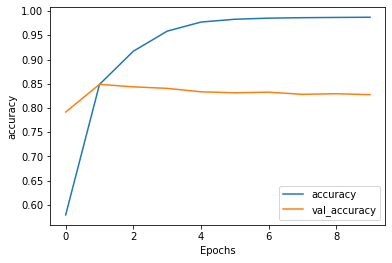

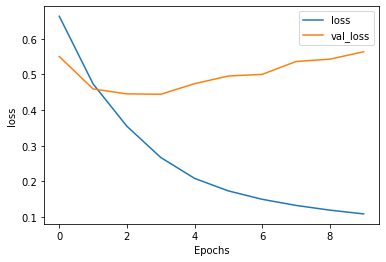

In [9]:
# Plot the accuracy and loss history
plot_graphs(history_flatten, 'accuracy')
plot_graphs(history_flatten, 'loss')

#### LSTM Model

In [10]:
# Parameters
embedding_dim = 16
lstm_dim = 32
dense_dim = 6

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [11]:
NUM_EPOCHS = 10
BATCH_SIZE = 256

# Train the model
history_lstm = model_lstm.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10


2022-09-17 17:18:32.384488: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


98/98 [==============================] - 5s 15ms/step - loss: 0.6006 - accuracy: 0.6550 - val_loss: 0.4296 - val_accuracy: 0.8146
Epoch 2/10
98/98 [==============================] - 1s 12ms/step - loss: 0.3913 - accuracy: 0.8341 - val_loss: 0.4049 - val_accuracy: 0.8237
Epoch 3/10
98/98 [==============================] - 1s 12ms/step - loss: 0.3070 - accuracy: 0.8817 - val_loss: 0.3666 - val_accuracy: 0.8413
Epoch 4/10
98/98 [==============================] - 1s 12ms/step - loss: 0.2468 - accuracy: 0.9114 - val_loss: 0.4010 - val_accuracy: 0.8362
Epoch 5/10
98/98 [==============================] - 1s 12ms/step - loss: 0.2140 - accuracy: 0.9268 - val_loss: 0.3855 - val_accuracy: 0.8396
Epoch 6/10
98/98 [==============================] - 1s 12ms/step - loss: 0.1870 - accuracy: 0.9379 - val_loss: 0.4323 - val_accuracy: 0.8339
Epoch 7/10
98/98 [==============================] - 1s 12ms/step - loss: 0.1724 - accuracy: 0.9440 - val_loss: 0.4594 - val_accuracy: 0.8250
Epoch 8/10
98/98 [======

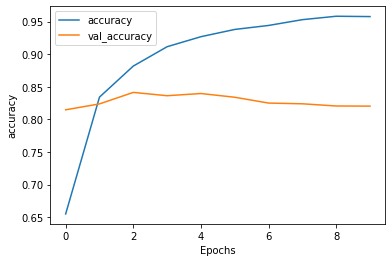

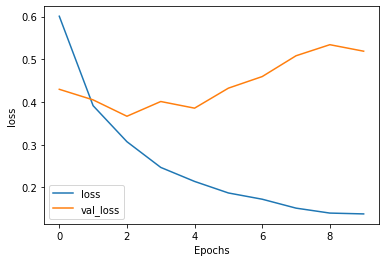

In [12]:
# Plot the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

#### GRU: simpler version LSTM.
faster results and sacrifice some accuracy

In [13]:
import tensorflow as tf

# Parameters
embedding_dim = 16
gru_dim = 32
dense_dim = 6

# Model Definition with GRU
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               9600      
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [14]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_gru = model_gru.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 4s 12ms/step - loss: 0.6123 - accuracy: 0.6290 - val_loss: 0.3975 - val_accuracy: 0.8308
Epoch 2/10
196/196 [==============================] - 2s 11ms/step - loss: 0.3391 - accuracy: 0.8586 - val_loss: 0.3548 - val_accuracy: 0.8491
Epoch 3/10
196/196 [==============================] - 2s 10ms/step - loss: 0.2524 - accuracy: 0.9022 - val_loss: 0.3613 - val_accuracy: 0.8441
Epoch 4/10
196/196 [==============================] - 2s 10ms/step - loss: 0.2064 - accuracy: 0.9255 - val_loss: 0.4050 - val_accuracy: 0.8383
Epoch 5/10
196/196 [==============================] - 2s 11ms/step - loss: 0.1695 - accuracy: 0.9398 - val_loss: 0.4318 - val_accuracy: 0.8329
Epoch 6/10
196/196 [==============================] - 2s 11ms/step - loss: 0.1309 - accuracy: 0.9572 - val_loss: 0.5466 - val_accuracy: 0.8207
Epoch 7/10
196/196 [==============================] - 2s 10ms/step - loss: 0.1105 - accuracy: 0.9649 - val_loss: 0.5614 - val_accuracy: 0.8254

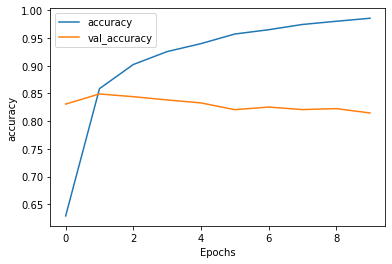

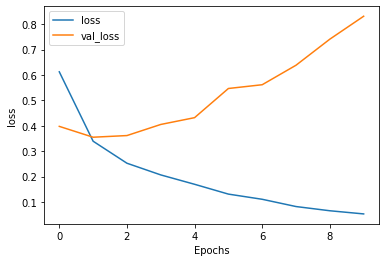

In [15]:
# Plot the accuracy and loss history
plot_graphs(history_gru, 'accuracy')
plot_graphs(history_gru, 'loss')

#### Convolution: a layer to extract features from dataset

In [16]:
# Parameters
embedding_dim = 16
filters = 128
kernel_size = 5
dense_dim = 6

# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_conv.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_6 (Dense)             (None, 6)                 774       
                                                                 
 dense_7 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
________________________________________________

In [17]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_conv = model_conv.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10


2022-09-17 17:32:36.931529: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


196/196 [==============================] - 3s 3ms/step - loss: 0.5561 - accuracy: 0.6949 - val_loss: 0.3665 - val_accuracy: 0.8406
Epoch 2/10
196/196 [==============================] - 1s 3ms/step - loss: 0.3046 - accuracy: 0.8731 - val_loss: 0.3502 - val_accuracy: 0.8474
Epoch 3/10
196/196 [==============================] - 1s 3ms/step - loss: 0.2451 - accuracy: 0.9035 - val_loss: 0.3683 - val_accuracy: 0.8439
Epoch 4/10
196/196 [==============================] - 1s 3ms/step - loss: 0.2099 - accuracy: 0.9189 - val_loss: 0.4028 - val_accuracy: 0.8378
Epoch 5/10
196/196 [==============================] - 1s 3ms/step - loss: 0.1825 - accuracy: 0.9346 - val_loss: 0.4453 - val_accuracy: 0.8288
Epoch 6/10
196/196 [==============================] - 1s 3ms/step - loss: 0.1616 - accuracy: 0.9429 - val_loss: 0.4849 - val_accuracy: 0.8261
Epoch 7/10
196/196 [==============================] - 1s 3ms/step - loss: 0.1432 - accuracy: 0.9497 - val_loss: 0.5251 - val_accuracy: 0.8188
Epoch 8/10
196/19

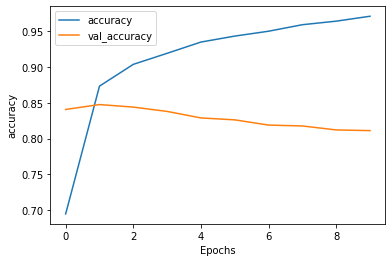

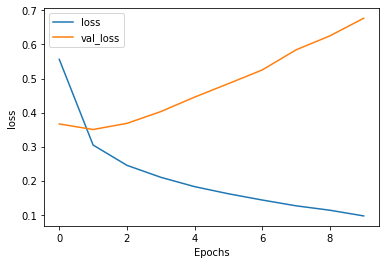

In [18]:
# Plot the accuracy and loss history
plot_graphs(history_conv, 'accuracy')
plot_graphs(history_conv, 'loss')